# COGS 108 - Final Project 

# Overview

Games nowadays are often categorized fairly broadly, with many falling into the categories of shooters, rpgs, rogue-likes, and so on. Our main goal with this project is to see what type of categories tend to get the best user responses to them and how this response has shifted over time. We wanted to figure out what is the current trend for popular game categories. We will split this up by seeing the trends for each specific year and how the reception for the game has been.

We will utilize two datasets, one for Steam games and one for mobile games in order to see if there's a category more suited for mobile devices compared to computers.

# Names

- Edward Xie
- Simon Fei

# Group Members IDs

- Edwardxie72---A15534895
- Simonfei123---A15658075

# Research Question

What type of game categories get the best user ratings and how has this trend changed over the years. 

Our second goal is to see whether these trends differ between mobile games and PC games.

## Background and Prior Work

## TODO
*Fill in your background and prior work here* 

References (include links):
- 1)
- 2)

# Hypothesis


## TODO
*Fill in your hypotheses here*

# Dataset(s)

*Dataset Information*

- Dataset Name: Steam Store Games
- Link to the dataset: https://www.kaggle.com/nikdavis/steam-store-games
- Number of observations: 27033

This dataset contains 27033 games from steam and it includes information on the games. The data we will be utilizing for each game is the categories of the game, the genre of the game, the steamspy tags of the game, the number of positive ratings for the game, and the number of negative ratings for the game.

- Dataset Name: Google Store Play Apps
- Link to the dataset: https://www.kaggle.com/gauthamp10/google-playstore-apps#Google-Playstore-Full.csv
- Number of observations: 244407

This dataset contains 244407 apps from the play store. With this data set we will extract all the games and from these games, the data we will utilize from them is the category of the game, the rating for the app, and the review count for the app.

*How we will combine the datasets:*
We will be treating these as seperate databases, but will use the results to compare the differences between games on the computer and games on a mobile device to see if there is some difference in the trends between these.


# Setup

In [2]:
#Imports (Following A2 as a guideline for processing data)
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import seaborn as sns

In [3]:
# Configure libraries(taken from A2)
# The seaborn library makes plots look nicer
sns.set()
sns.set_context('talk')

# Don't display too many rows/cols of DataFrames
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8

# Round decimals when displaying DataFrames
pd.set_option('precision', 2)

# Data Cleaning

## TODO
Describe your data cleaning steps here.

In [4]:
# Read in data
df_steam = pd.read_csv('steam.csv', low_memory=False)
df_googleplay = pd.read_csv('Google-Playstore-Full.csv', low_memory=False)

In [5]:
# Preview and clean up steam data set first
df_steam.head(5)

,appid,name,release_date,english,...,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,...,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,...,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,...,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,...,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,...,624,415,5000000-10000000,3.99


In [6]:
# Start by dropping unwanted data, keep the name so we have some way to identify apps, but not neccesary
del df_steam['appid']
del df_steam['english']
del df_steam['developer']
del df_steam['publisher']
del df_steam['platforms']
del df_steam['required_age']
del df_steam['achievements']
del df_steam['average_playtime']
del df_steam['median_playtime']
del df_steam['price']
del df_steam['owners']  # We drop owners because it gives a range which might make data inconsistent, instead we will weigh off each rating

In [7]:
# Rename categories before we start cleaning data
df_steam.columns = ['Name', 'Year', 'Steam Categories', 'Genre', 'Steamspy Categories', 'Positive Ratings', 'Negative Ratings']

In [8]:
# Extract only the year from the release date because we analyze by year
def extract_year(string):
    return int(string[:4])  # Only need first 4 characters for year

In [9]:
df_steam['Year'] = df_steam['Year'].apply(extract_year)  # Change all years in our df

In [10]:
# Preview and clean up Google Play Data
df_googleplay.head(5)

,App Name,Category,Rating,Reviews,...,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,DoorDash - Food Delivery,FOOD_AND_DRINK,4.548561573,305034,...,NaN,NaN,NaN,NaN
1,TripAdvisor Hotels Flights Restaurants Attract...,TRAVEL_AND_LOCAL,4.400671482,1207922,...,NaN,NaN,NaN,NaN
2,Peapod,SHOPPING,3.656329393,1967,...,NaN,NaN,NaN,NaN
3,foodpanda - Local Food Delivery,FOOD_AND_DRINK,4.107232571,389154,...,NaN,NaN,NaN,NaN
4,My CookBook Pro (Ad Free),FOOD_AND_DRINK,4.647752285,2291,...,NaN,NaN,NaN,NaN


In [11]:
# Start by dropping unwanted data, keep the name so we have some way to identify apps, but not neccesary
del df_googleplay['Installs']  # We don't care about installs for same reason as steam, use number of ratings instead
del df_googleplay['Size']
del df_googleplay['Price']
del df_googleplay['Content Rating']
del df_googleplay['Last Updated']
del df_googleplay['Minimum Version']
del df_googleplay['Latest Version']
del df_googleplay['Unnamed: 11']
del df_googleplay['Unnamed: 12']
del df_googleplay['Unnamed: 13']
del df_googleplay['Unnamed: 14']

In [12]:
df_googleplay = df_googleplay.dropna(subset=['Category', 'Rating', 'Reviews'])

In [13]:
# First start by dropping all non game category games, games will start with the string "GAME_" in category
df_googleplay = df_googleplay[df_googleplay['Category'].str.contains('GAME')]
df_googleplay = df_googleplay.reset_index(drop=True)

In [14]:
# Add extra columns to steam one for the average rating(out of 10) and total number of ratings(Pos rating/(Pos + neg rating))
df_steam['AvgRating'] = df_steam['Positive Ratings'].div(df_steam['Positive Ratings'].add(df_steam['Negative Ratings']))
df_steam['NumRating'] = df_steam['Positive Ratings'].add(df_steam['Negative Ratings'])

In [15]:
# Add extra columns to googleplay, one for avg rating(out of 10) and rename total to match steam
df_googleplay['Rating'] = df_googleplay['Rating'].astype(float)
df_googleplay['AvgRating'] = df_googleplay['Rating'].mul(2)
df_googleplay.rename(columns = {'Reviews':'NumRating'}, inplace = True) 

In [16]:
# Clean up the categories for the games
df_googleplay['Category'] = df_googleplay['Category'].str.slice(start=5)

In [17]:
# Preview mostly cleaned up data
df_steam.head(5)

,Name,Year,Steam Categories,Genre,...,Positive Ratings,Negative Ratings,AvgRating,NumRating
0,Counter-Strike,2000,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,124534,3339,0.97,127873
1,Team Fortress Classic,1999,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,3318,633,0.84,3951
2,Day of Defeat,2003,Multi-player;Valve Anti-Cheat enabled,Action,...,3416,398,0.90,3814
3,Deathmatch Classic,2001,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,1273,267,0.83,1540
4,Half-Life: Opposing Force,1999,Single-player;Multi-player;Valve Anti-Cheat en...,Action,...,5250,288,0.95,5538


In [18]:
df_googleplay.head(5)

,App Name,Category,Rating,NumRating,AvgRating
0,King of Crabs,ACTION,3.28,785,6.56
1,Match 3 App Rewards: Daily Game Rewards,CASUAL,4.52,248,9.04
2,Brown Dust,ROLE_PLAYING,4.48,70260,8.95
3,Poly - Coloring Puzzle Art Book,PUZZLE,4.58,878,9.16
4,Legend of Empress,ROLE_PLAYING,3.82,750,7.64


In [19]:
del df_googleplay['AvgRating'] # Avg Rating is redundant since it's just (Rating * 2)
df_googleplay['NumRating'] = df_googleplay['NumRating'].astype(int)

In [20]:
df_googleplay['NumRating'] = df_googleplay['NumRating'].astype(int)

In [21]:
df_googleplay.head(5)

,App Name,Category,Rating,NumRating
0,King of Crabs,ACTION,3.28,785
1,Match 3 App Rewards: Daily Game Rewards,CASUAL,4.52,248
2,Brown Dust,ROLE_PLAYING,4.48,70260
3,Poly - Coloring Puzzle Art Book,PUZZLE,4.58,878
4,Legend of Empress,ROLE_PLAYING,3.82,750


In [22]:
# Clean up categories
# Convert Steam Categories + Genre + Steamspy Categories into one category and put it in an array
print(df_steam["Steam Categories"].unique(), len(df_steam["Steam Categories"].unique()))

['Multi-player;Online Multi-Player;Local Multi-Player;Valve Anti-Cheat enabled'
 'Multi-player;Valve Anti-Cheat enabled'
 'Single-player;Multi-player;Valve Anti-Cheat enabled' ...
 'Online Multi-Player;Steam Achievements;Full controller support;In-App Purchases;Steam Cloud'
 'Multi-player;Local Multi-Player;Co-op;Local Co-op;Shared/Split Screen'
 'Multi-player;Online Multi-Player;Cross-Platform Multiplayer;Stats'] 3333


In [23]:
print(df_steam["Genre"].unique(), len(df_steam["Genre"].unique()))

['Action' 'Action;Free to Play' 'Action;Free to Play;Strategy' ...
 'Action;Adventure;Indie;Massively Multiplayer;RPG;Strategy;Early Access'
 'Action;Adventure;Casual;Free to Play;Indie;RPG;Simulation;Sports;Strategy'
 'Casual;Free to Play;Massively Multiplayer;RPG;Early Access'] 1552


In [24]:
print(df_steam["Steamspy Categories"].unique(), len(df_steam["Steamspy Categories"].unique()))

['Action;FPS;Multiplayer' 'FPS;World War II;Multiplayer'
 'FPS;Action;Sci-fi' ... 'Casual;Adventure;Arcade'
 'Free to Play;Visual Novel' 'Early Access;Adventure;Sexual Content'] 6423


In [25]:
# Convert Google Play Categories into same style as Steam
df_googleplay["Category"].unique()

array(['ACTION', 'CASUAL', 'ROLE_PLAYING', 'PUZZLE', 'RACING',
       'ADVENTURE', 'ARCADE', 'STRATEGY', 'SPORTS', 'SIMULATION', 'MUSIC',
       'EDUCATIONAL', 'WORD', 'TRIVIA', 'BOARD', 'CASINO', 'CARD'],
      dtype=object)

In [26]:
# A function that saves arrays into text files
def array2txt(array, file_name = 'output.txt'):
    with open(file_name, "w") as txt_file:
        for i in array:
            txt_file.write(i + "\n")

In [27]:
# Save the uncleaned categories into text files
array2txt(df_steam["Steam Categories"].unique(), 'steam_categories_uncleaned.txt')


In [28]:
# Split the categories connected by semicolons
def split_semi(array):
    output = []
    for i in array:
        output.extend(i.split(';'))
    return output

In [29]:
split_semi(df_steam["Steam Categories"].unique())
len(split_semi(df_steam["Steam Categories"].unique()))

21447

In [30]:
# Filter identical items in a list
def unique(list1): 
    x = np.array(list1) 
    #print(np.unique(x))
    return np.unique(x)

In [31]:
unique(["1","1",'2','3'])

array(['1', '2', '3'], dtype='<U1')

In [32]:
# Cleaned steam categories
array_steam = unique(split_semi(df_steam["Steam Categories"].unique()))
array_steam

array(['Captions available', 'Co-op', 'Commentary available',
       'Cross-Platform Multiplayer', 'Full controller support',
       'In-App Purchases', 'Includes Source SDK', 'Includes level editor',
       'Local Co-op', 'Local Multi-Player', 'MMO', 'Mods',
       'Mods (require HL2)', 'Multi-player', 'Online Co-op',
       'Online Multi-Player', 'Partial Controller Support',
       'Shared/Split Screen', 'Single-player', 'Stats',
       'Steam Achievements', 'Steam Cloud', 'Steam Leaderboards',
       'Steam Trading Cards', 'Steam Turn Notifications',
       'Steam Workshop', 'SteamVR Collectibles', 'VR Support',
       'Valve Anti-Cheat enabled'], dtype='<U26')

In [33]:
# Cleaned steam genres
array_genre = unique(split_semi(df_steam["Genre"].unique()))
array_genre

array(['Accounting', 'Action', 'Adventure', 'Animation & Modeling',
       'Audio Production', 'Casual', 'Design & Illustration',
       'Documentary', 'Early Access', 'Education', 'Free to Play',
       'Game Development', 'Gore', 'Indie', 'Massively Multiplayer',
       'Nudity', 'Photo Editing', 'RPG', 'Racing', 'Sexual Content',
       'Simulation', 'Software Training', 'Sports', 'Strategy',
       'Tutorial', 'Utilities', 'Video Production', 'Violent',
       'Web Publishing'], dtype='<U21')

In [34]:
# Cleaned steamspy categories
array_steampy = unique(split_semi(df_steam["Steamspy Categories"].unique()))
array_steampy

array(['1980s', "1990's", '2.5D', '2D', '2D Fighter', '360 Video', '3D',
       '3D Platformer', '3D Vision', '4 Player Local', '4X', '6DOF',
       'Abstract', 'Action', 'Action RPG', 'Action-Adventure',
       'Adventure', 'Agriculture', 'Aliens', 'Alternate History',
       'America', 'Animation & Modeling', 'Anime', 'Arcade',
       'Arena Shooter', 'Assassin', 'Atmospheric', 'Audio Production',
       'BMX', 'Base-Building', 'Baseball', 'Basketball', 'Batman',
       'Battle Royale', "Beat 'em up", 'Beautiful', 'Benchmark', 'Bikes',
       'Blood', 'Board Game', 'Bowling', 'Building', 'Bullet Hell',
       'Bullet Time', 'CRPG', 'Capitalism', 'Card Game', 'Cartoon',
       'Cartoony', 'Casual', 'Cats', 'Character Action Game',
       'Character Customization', 'Chess', 'Choices Matter',
       'Choose Your Own Adventure', 'Cinematic', 'City Builder',
       'Class-Based', 'Classic', 'Clicker', 'Co-op', 'Cold War',
       'Colorful', 'Comedy', 'Comic Book', 'Competitive', 'Controll

In [35]:
# Save cleaned categories into text files
array2txt(array_steam, 'steam_categories_cleaned.txt')
array2txt(array_genre, 'steam_genres_cleaned.txt')
array2txt(array_steampy, 'steamspy_categories_cleaned.txt')

In [36]:
# Combine all the categories into one single array
array_googleplay = df_googleplay["Category"].unique()
all_categories = np.concatenate((array_steam, array_genre, array_steampy, array_googleplay), axis=0)
print(all_categories, len(all_categories))

['Captions available' 'Co-op' 'Commentary available'
 'Cross-Platform Multiplayer' 'Full controller support' 'In-App Purchases'
 'Includes Source SDK' 'Includes level editor' 'Local Co-op'
 'Local Multi-Player' 'MMO' 'Mods' 'Mods (require HL2)' 'Multi-player'
 'Online Co-op' 'Online Multi-Player' 'Partial Controller Support'
 'Shared/Split Screen' 'Single-player' 'Stats' 'Steam Achievements'
 'Steam Cloud' 'Steam Leaderboards' 'Steam Trading Cards'
 'Steam Turn Notifications' 'Steam Workshop' 'SteamVR Collectibles'
 'VR Support' 'Valve Anti-Cheat enabled' 'Accounting' 'Action' 'Adventure'
 'Animation & Modeling' 'Audio Production' 'Casual'
 'Design & Illustration' 'Documentary' 'Early Access' 'Education'
 'Free to Play' 'Game Development' 'Gore' 'Indie' 'Massively Multiplayer'
 'Nudity' 'Photo Editing' 'RPG' 'Racing' 'Sexual Content' 'Simulation'
 'Software Training' 'Sports' 'Strategy' 'Tutorial' 'Utilities'
 'Video Production' 'Violent' 'Web Publishing' '1980s' "1990's" '2.5D'
 '2D' 

In [37]:
# Also prepare steam and google play as 2 separate groups of categories
all_steam = np.concatenate((array_steam, array_genre, array_steampy), axis=0)
print(all_steam, len(all_steam))
array2txt(all_steam, 'all_steam_categories_cleaned.txt')
array2txt(array_googleplay, 'googleplay_categories.txt')

['Captions available' 'Co-op' 'Commentary available'
 'Cross-Platform Multiplayer' 'Full controller support' 'In-App Purchases'
 'Includes Source SDK' 'Includes level editor' 'Local Co-op'
 'Local Multi-Player' 'MMO' 'Mods' 'Mods (require HL2)' 'Multi-player'
 'Online Co-op' 'Online Multi-Player' 'Partial Controller Support'
 'Shared/Split Screen' 'Single-player' 'Stats' 'Steam Achievements'
 'Steam Cloud' 'Steam Leaderboards' 'Steam Trading Cards'
 'Steam Turn Notifications' 'Steam Workshop' 'SteamVR Collectibles'
 'VR Support' 'Valve Anti-Cheat enabled' 'Accounting' 'Action' 'Adventure'
 'Animation & Modeling' 'Audio Production' 'Casual'
 'Design & Illustration' 'Documentary' 'Early Access' 'Education'
 'Free to Play' 'Game Development' 'Gore' 'Indie' 'Massively Multiplayer'
 'Nudity' 'Photo Editing' 'RPG' 'Racing' 'Sexual Content' 'Simulation'
 'Software Training' 'Sports' 'Strategy' 'Tutorial' 'Utilities'
 'Video Production' 'Violent' 'Web Publishing' '1980s' "1990's" '2.5D'
 '2D' 

# Datasets Compilation

Create datasets to be used in data analysis

### all the datasets available so far:
`df_steam` <br>
`df_googleplay` <br>
`array_steam` <br>
`array_genre` <br>
`array_steampy` <br>
`array_googleplay` <br>
`all_steam` <br>
`all_categories` <br>
`steam_avg` <br>
`googleplay_avg` <br>

In [38]:
# mean rating of steam
df_steam['AvgRating']
df_steam['NumRating'].sum()
steam_avg = np.multiply(df_steam['AvgRating'], df_steam['NumRating']).sum()/df_steam['NumRating'].sum() * 5
steam_avg

4.129128248469181

In [39]:
# mean rating of googleplay
googleplay_avg = np.multiply(df_googleplay['Rating'], df_googleplay['NumRating']).sum()/df_googleplay['NumRating'].sum()
googleplay_avg

4.4378157379329695

In [40]:
# Find similarities between the two
def similar_categories(a, b):
    a_set = set(a)
    b_set = set(b)

    if(len(a_set.intersection(b_set)) > 0):
        return a_set.intersection(b_set);
    else:
        return "no similarities"

In [41]:
print(similar_categories([x.lower() for x in array_genre], [y.lower() for y in array_googleplay]))

{'adventure', 'casual', 'simulation', 'sports', 'action', 'racing', 'strategy'}


In [ ]:
# Above categories are what we care about when we run code, so get our similar categories extracted
# ALL EXTRACTION IS WEIGHTED, BASED ON NUM OF REVIEWS, NOT NUM OF GAMES
# ADVENTURE FOR BOTH
steam_adv = df_steam[df_steam['Genre'].str.contains("adventure", case=False)]
steam_adv.head(5)
#steam_adv_avg = np.multiply(steam_adv['AvgRating'], steam_adv['NumRating']).sum()/steam_adv['NumRating'].sum() * 5
#steam_adv_avg
#google_adv = df_googleplay[df_googleplay['Category'].str.contains("adventure", case=False)]
#google_adv
#google_adv_avg = np.multiply(google_adv['Rating'], google_adv['NumRating']).sum()/google_adv['NumRating'].sum()
#google_adv_avg

In [55]:
# CASUAL FOR BOTH
steam_cas = df_steam[df_steam['Genre'].str.contains("casual", case=False)]
steam_cas
steam_cas_avg = np.multiply(steam_cas['AvgRating'], steam_cas['NumRating']).sum()/steam_cas['NumRating'].sum() * 5
steam_cas_avg
google_cas = df_googleplay[df_googleplay['Category'].str.contains("casual", case=False)]
google_cas
google_cas_avg = np.multiply(google_cas['Rating'], google_cas['NumRating']).sum()/google_cas['NumRating'].sum()
google_cas_avg

4.422157355730271

In [56]:
# SIMULATION FOR BOTH
steam_sim = df_steam[df_steam['Genre'].str.contains("simulation", case=False)]
steam_sim
steam_sim_avg = np.multiply(steam_sim['AvgRating'], steam_sim['NumRating']).sum()/steam_sim['NumRating'].sum() * 5
steam_sim_avg
google_sim = df_googleplay[df_googleplay['Category'].str.contains("simulation", case=False)]
google_sim
google_sim_avg = np.multiply(google_sim['Rating'], google_sim['NumRating']).sum()/google_sim['NumRating'].sum()
google_sim_avg

4.441160775274634

In [57]:
# SPORTS FOR BOTH
steam_spt = df_steam[df_steam['Genre'].str.contains("sports", case=False)]
steam_spt
steam_spt_avg = np.multiply(steam_spt['AvgRating'], steam_spt['NumRating']).sum()/steam_spt['NumRating'].sum() * 5
steam_spt_avg
google_spt = df_googleplay[df_googleplay['Category'].str.contains("sports", case=False)]
google_spt
google_spt_avg = np.multiply(google_spt['Rating'], google_spt['NumRating']).sum()/google_spt['NumRating'].sum()
google_spt_avg

4.429699906912171

In [58]:
# ACTION FOR BOTH
steam_act = df_steam[df_steam['Genre'].str.contains("action", case=False)]
steam_act
steam_act_avg = np.multiply(steam_act['AvgRating'], steam_act['NumRating']).sum()/steam_act['NumRating'].sum() * 5
steam_act_avg
google_act = df_googleplay[df_googleplay['Category'].str.contains("action", case=False)]
google_act
google_act_avg = np.multiply(google_act['Rating'], google_act['NumRating']).sum()/google_act['NumRating'].sum()
google_act_avg

4.4414171484927625

In [59]:
# RACING FOR BOTH
steam_rac = df_steam[df_steam['Genre'].str.contains("racing", case=False)]
steam_rac
steam_rac_avg = np.multiply(steam_rac['AvgRating'], steam_rac['NumRating']).sum()/steam_rac['NumRating'].sum() * 5
steam_rac_avg
google_rac = df_googleplay[df_googleplay['Category'].str.contains("racing", case=False)]
google_rac
google_rac_avg = np.multiply(google_rac['Rating'], google_rac['NumRating']).sum()/google_rac['NumRating'].sum()
google_rac_avg

4.423843398407345

In [61]:
# STRATEGY FOR BOTH
steam_stg = df_steam[df_steam['Genre'].str.contains("strategy", case=False)]
steam_stg
steam_stg_avg = np.multiply(steam_stg['AvgRating'], steam_stg['NumRating']).sum()/steam_stg['NumRating'].sum() * 5
steam_stg_avg
google_stg = df_googleplay[df_googleplay['Category'].str.contains("strategy", case=False)]
google_stg
google_stg_avg = np.multiply(google_stg['Rating'], google_stg['NumRating']).sum()/google_stg['NumRating'].sum()
google_stg_avg

4.4927580266566105

###For similar data between the two, usable information is<br>
Adventure Games:<br>
    &nbsp;&nbsp;&nbsp;&nbsp;Steam:<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;DF: steam_adv<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Avg Rating: steam_adv_avg<br>
    &nbsp;&nbsp;&nbsp;&nbsp;Google Play:<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;DF: google_adv<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Avg Rating: google_adv_avg<br>
Casual Games:<br>
    &nbsp;&nbsp;&nbsp;&nbsp;Steam:<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;DF: steam_cas<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Avg Rating: steam_cas_avg<br>
    &nbsp;&nbsp;&nbsp;&nbsp;Google Play:<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;DF: google_cas<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Avg Rating: google_cas_avg<br>
Simulation Games:<br>
    &nbsp;&nbsp;&nbsp;&nbsp;Steam:<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;DF: steam_sim<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Avg Rating: steam_sim_avg<br>
    &nbsp;&nbsp;&nbsp;&nbsp;Google Play:<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;DF: google_sim<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Avg Rating: google_sim_avg<br>
Sports Games:<br>
    &nbsp;&nbsp;&nbsp;&nbsp;Steam:<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;DF: steam_spt<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Avg Rating: steam_spt_avg<br>
    &nbsp;&nbsp;&nbsp;&nbsp;Google Play:<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;DF: google_spt<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Avg Rating: google_spt_avg<br>
Action Games:<br>
    &nbsp;&nbsp;&nbsp;&nbsp;Steam:<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;DF: steam_act<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Avg Rating: steam_act_avg<br>
    &nbsp;&nbsp;&nbsp;&nbsp;Google Play:<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;DF: google_act<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Avg Rating: google_act_avg<br>
Racing Games:<br>
    &nbsp;&nbsp;&nbsp;&nbsp;Steam:<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;DF: steam_rac<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Avg Rating: steam_rac_avg<br>
    &nbsp;&nbsp;&nbsp;&nbsp;Google Play:<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;DF: google_rac<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Avg Rating: google_rac_avg<br>
Strategy Games:<br>
    &nbsp;&nbsp;&nbsp;&nbsp;Steam:<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;DF: steam_stg<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Avg Rating: steam_stg_avg<br>
    &nbsp;&nbsp;&nbsp;&nbsp;Google Play:<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;DF: google_stg<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Avg Rating: google_stg_avg<br>

# Data Analysis & Results

Include cells that describe the steps in your data analysis.

(array([ 668.,   27.,   37.,  108.,  111.,  223.,  326.,  267.,  556.,
         417.,  664.,  626., 1337.,  806.,  907., 1354., 1647., 1591.,
        1861., 1590., 2318., 2105., 2089., 1874., 3566.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
        2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ]),
 <a list of 25 Patch objects>)

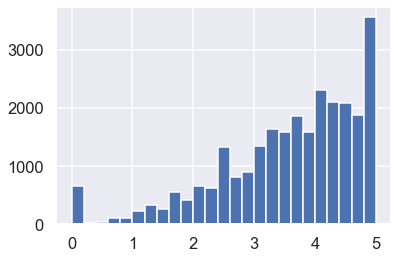

In [39]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION
plt.hist(df_steam['AvgRating']*5, bins = 25) # Unweighted steam ratings distribution histogram

(array([1.625000e+03, 5.370000e+02, 8.250000e+02, 8.050000e+03,
        1.280200e+04, 1.455200e+04, 4.731800e+04, 4.878700e+04,
        7.320800e+04, 7.044400e+04, 1.524630e+05, 1.645770e+05,
        1.279400e+06, 5.369600e+05, 4.380050e+05, 7.209080e+05,
        9.598900e+05, 1.967427e+06, 1.572702e+06, 1.974187e+06,
        2.684326e+06, 6.714170e+06, 4.358539e+06, 5.788099e+06,
        3.213881e+06]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
        2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ]),
 <a list of 25 Patch objects>)

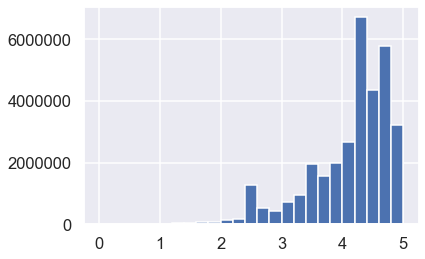

In [40]:
plt.hist(df_steam['AvgRating']*5, weights = df_steam['NumRating'], bins = 25) # Weighted steam ratings distribution histogram

(array([4.600e+01, 0.000e+00, 3.000e+00, 5.000e+00, 8.000e+00, 4.000e+00,
        3.600e+01, 1.500e+01, 4.000e+01, 3.000e+01, 4.400e+01, 8.400e+01,
        2.320e+02, 1.810e+02, 2.600e+02, 4.560e+02, 6.910e+02, 1.120e+03,
        1.936e+03, 2.694e+03, 3.647e+03, 4.332e+03, 3.251e+03, 1.632e+03,
        1.761e+03]),
 array([1.  , 1.16, 1.32, 1.48, 1.64, 1.8 , 1.96, 2.12, 2.28, 2.44, 2.6 ,
        2.76, 2.92, 3.08, 3.24, 3.4 , 3.56, 3.72, 3.88, 4.04, 4.2 , 4.36,
        4.52, 4.68, 4.84, 5.  ]),
 <a list of 25 Patch objects>)

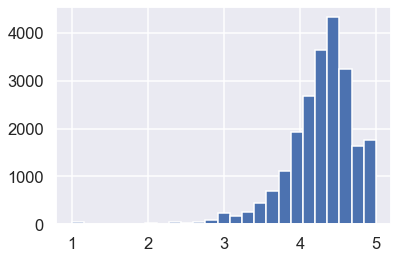

In [41]:
plt.hist(df_googleplay['Rating'], bins = 25) # Unweighted googleplay ratings distribution histogram

(array([6.00000000e+01, 0.00000000e+00, 3.90000000e+01, 1.71000000e+02,
        7.48000000e+02, 1.15700000e+03, 1.31900000e+03, 1.21400000e+03,
        7.95000000e+02, 1.37280000e+04, 3.35490000e+04, 7.74420000e+04,
        4.14120000e+04, 8.68120000e+04, 4.29777000e+05, 9.17688000e+05,
        2.88157700e+06, 1.56102290e+07, 3.41718130e+07, 1.11294063e+08,
        3.14314908e+08, 5.80888278e+08, 4.61236786e+08, 9.57058150e+07,
        4.70740800e+06]),
 array([1.  , 1.16, 1.32, 1.48, 1.64, 1.8 , 1.96, 2.12, 2.28, 2.44, 2.6 ,
        2.76, 2.92, 3.08, 3.24, 3.4 , 3.56, 3.72, 3.88, 4.04, 4.2 , 4.36,
        4.52, 4.68, 4.84, 5.  ]),
 <a list of 25 Patch objects>)

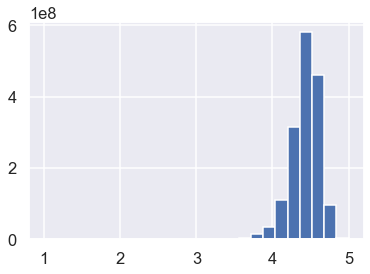

In [42]:
plt.hist(df_googleplay['Rating'], weights = df_googleplay['NumRating'], bins = 25) # Weighted googleplay ratings distribution histogram

In [43]:
# For plotting the regression line
# Let's fit an exponential function.  
# This looks like a line on a lof-log plot.
def myExpFunc(x, a, b):
    return a * np.power(x, b)

In [44]:
# For plotting a more complicated regression line
def myComplexFunc(x, a, b, c):
    return a * np.power(x, b) + c

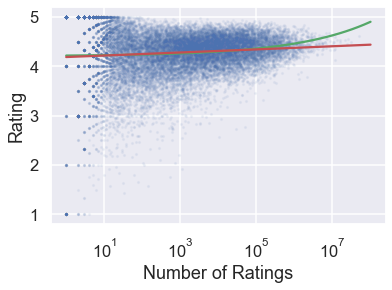

In [46]:
# googleplay Rating * Num of ratings Scatterplot (in log scale)
plt.scatter(df_googleplay['NumRating'], df_googleplay['Rating'], alpha=0.06,s=3)
plt.xscale('log')
a1, b1 = np.polyfit(df_googleplay['NumRating'], df_googleplay['Rating'], 1)
plt.xlabel("Number of Ratings")
plt.ylabel("Rating")

newX = np.logspace(0, 8, base=10)
popt, pcov = curve_fit(myComplexFunc, df_googleplay['NumRating'], df_googleplay['Rating'])
plt.plot(newX, myComplexFunc(newX, *popt), 'g-', 
         label="({0:.3f}*x**{1:.3f}) + {2:.3f}".format(*popt))
popt, pcov = curve_fit(myExpFunc, df_googleplay['NumRating'], df_googleplay['Rating'])
plt.plot(newX, myExpFunc(newX, *popt), 'r-', 
         label="({0:.3f}*x**{1:.3f})".format(*popt))


#x = np.linspace(10,10**7,100)
#y = a1 * x + b1
#plt.plot(x, y, 'r');  # dotted red

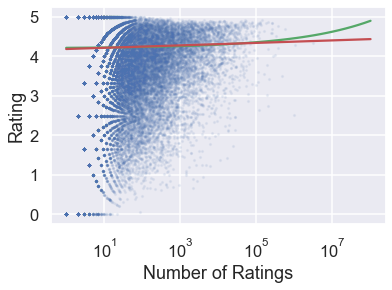

In [48]:
# steam Rating * Num of ratings Scatterplot (in log scale)
plt.scatter(df_steam['NumRating'], df_steam['AvgRating']*5, alpha=0.08,s=3)
plt.xscale('log')
plt.xlabel("Number of Ratings")
plt.ylabel("Rating")

newX = np.logspace(0, 8, base=10)
popt, pcov = curve_fit(myComplexFunc, df_googleplay['NumRating'], df_googleplay['Rating'])
plt.plot(newX, myComplexFunc(newX, *popt), 'g-', 
         label="({0:.3f}*x**{1:.3f}) + {2:.3f}".format(*popt))
popt, pcov = curve_fit(myExpFunc, df_googleplay['NumRating'], df_googleplay['Rating'])
plt.plot(newX, myExpFunc(newX, *popt), 'r-', 
         label="({0:.3f}*x**{1:.3f})".format(*popt))

In [63]:
# Extract the similar categories between the two
steam_similar = [steam_adv_avg, steam_cas_avg, steam_sim_avg, steam_spt_avg, steam_act_avg, steam_rac_avg, steam_stg_avg]
google_similar = [google_adv_avg, google_cas_avg, google_sim_avg, google_spt_avg, google_act_avg, google_rac_avg, google_stg_avg]

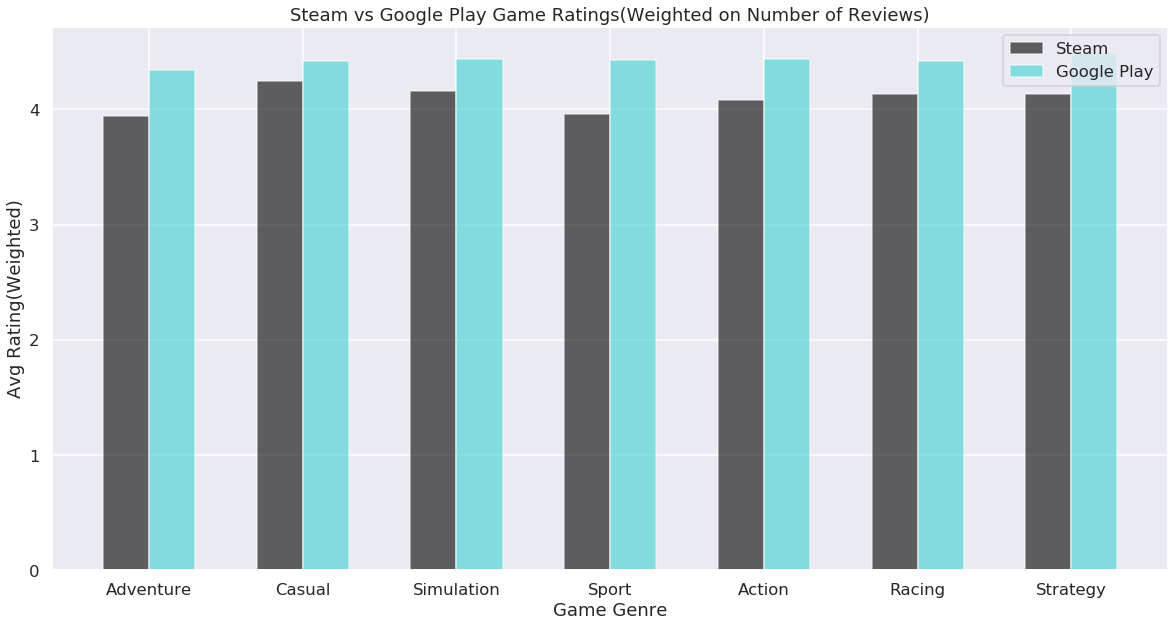

In [78]:
# Plot similar categories
n = 7  # 7 similar categories
fig, ax = plt.subplots(figsize=(20, 10))
index = np.arange(n)
bar_width = .3
opacity = .6
ax.bar(index, steam_similar, bar_width, alpha=opacity, color='black', label='Steam')
ax.bar(index + bar_width, google_similar, bar_width, alpha=opacity, color='#3fd2d1', label = 'Google Play')
ax.set_xlabel('Game Genre')
ax.set_ylabel('Avg Rating(Weighted)')
ax.set_title('Steam vs Google Play Game Ratings(Weighted on Number of Reviews)')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Adventure', 'Casual', 'Simulation', 'Sport', 'Action', 'Racing', 'Strategy'))
ax.legend()
plt.show()

In [ ]:
df_categories over time=pd.DataFrame({'x': range(df_), 
                                      'Action': np.random.randn(10), 
                                      'Adventure': np.random.randn(10)+range(1,11), 
                                      'Casual': np.random.randn(10)+range(11,21),
                                     'Indie': np.random.randn(10)+range(11,21),
                                     'RPG': np.random.randn(10)+range(11,21),
                                     'Racing': np.random.randn(10)+range(11,21),
                                     'Sports': np.random.randn(10)+range(11,21),
                                     'Strategy': np.random.randn(10)+range(11,21)})

# https://python-graph-gallery.com/122-multiple-lines-chart/

# Ethics & Privacy

*Fill in your ethics & privacy discussion here*

# Conclusion & Discussion

*Fill in your discussion information here*